# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import copy

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
anyio                       NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.8
colorama                    0.4.4
cycler                      0.10.0
cython_runt

In [3]:
adata = sc.datasets.paul15()

C:\Users\Admin\.conda\envs\IDOL\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

Let us work with a higher precision than the default 'float32' to ensure _exactly_ the same results across different computational platforms.

In [5]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [6]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [7]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [8]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:25)


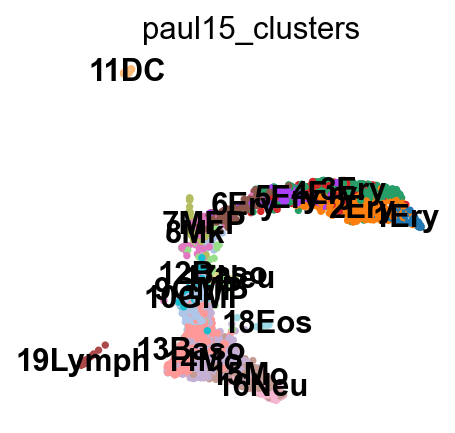

In [9]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This looks pretty messy.

## Optional: Denoising the graph

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It's very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. [Schiebinger et al. (2017)](https://doi.org/10.1101/191056) or [Tabaka et al. (2018)](https://doi.org/10.1101/512582). It's also related to the principles behind MAGIC [Dijk et al. (2018)](https://doi.org/10.1016/j.cell.2018.05.061).

<div class="alert alert-info">

**Note**
    
This is *not* a necessary step, neither for PAGA, nor clustering, nor pseudotime estimation. You might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results.
    
</div>  

In [10]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [11]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:22)


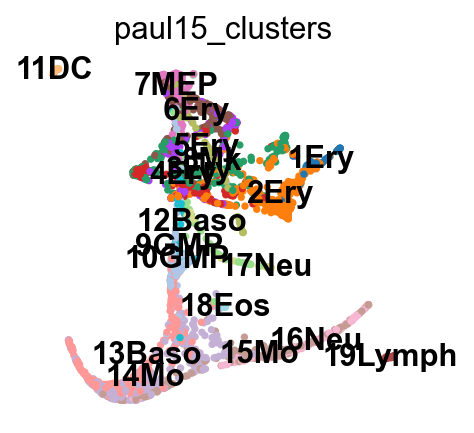

In [12]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

<div class="alert alert-info">

**Note**

Note that today, we'd use `sc.tl.leiden` - here, we use `sc.tl.louvain` the sake of reproducing the paper results.
    
</div>  

In [13]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [14]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


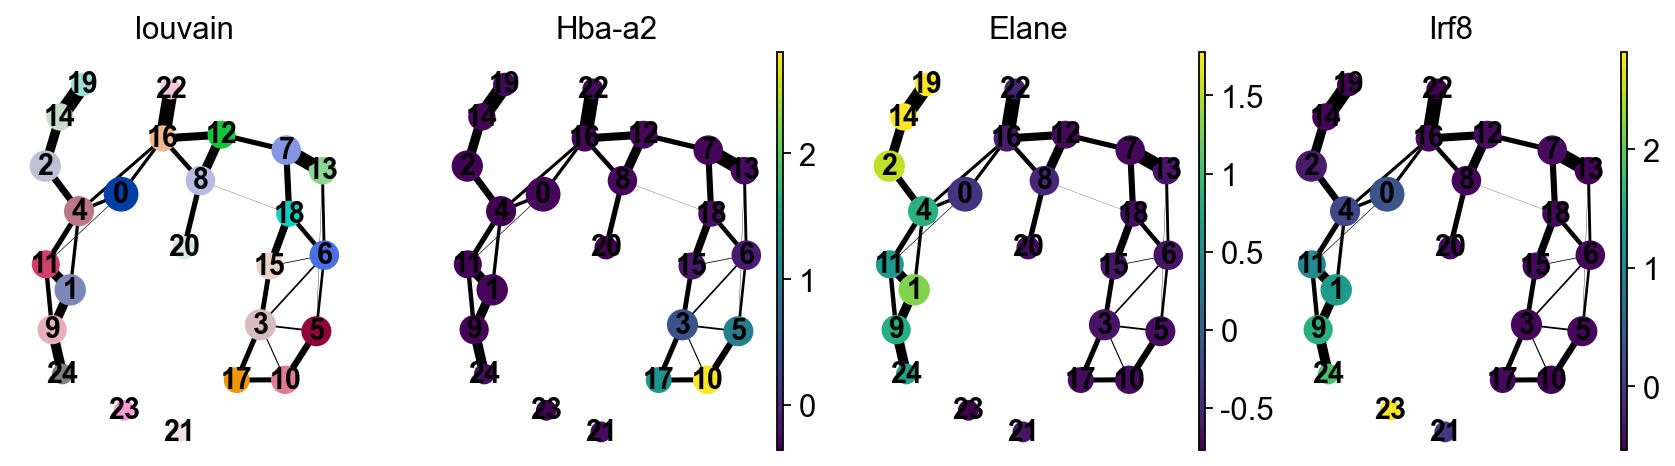

In [15]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


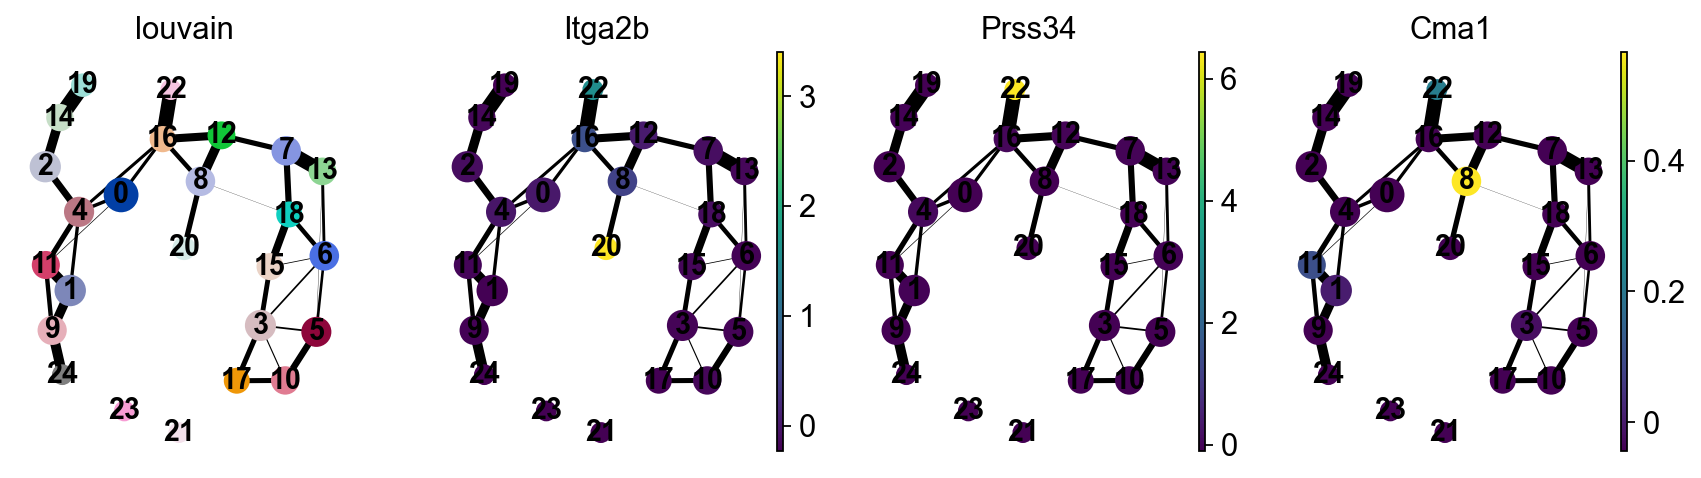

In [16]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Actually annotate the clusters --- note that *Cma1* is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

In [17]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [18]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [19]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

Let's use the annotated clusters for PAGA.

In [20]:
sc.tl.paga(adata, groups='louvain_anno')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes:>

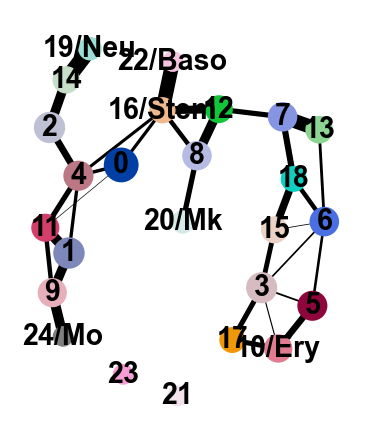

In [21]:
sc.pl.paga(adata, threshold=0.03, show=False)

## Recomputing the embedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [22]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:21)


Now we can see all marker genes also at single-cell resolution in a meaningful layout.

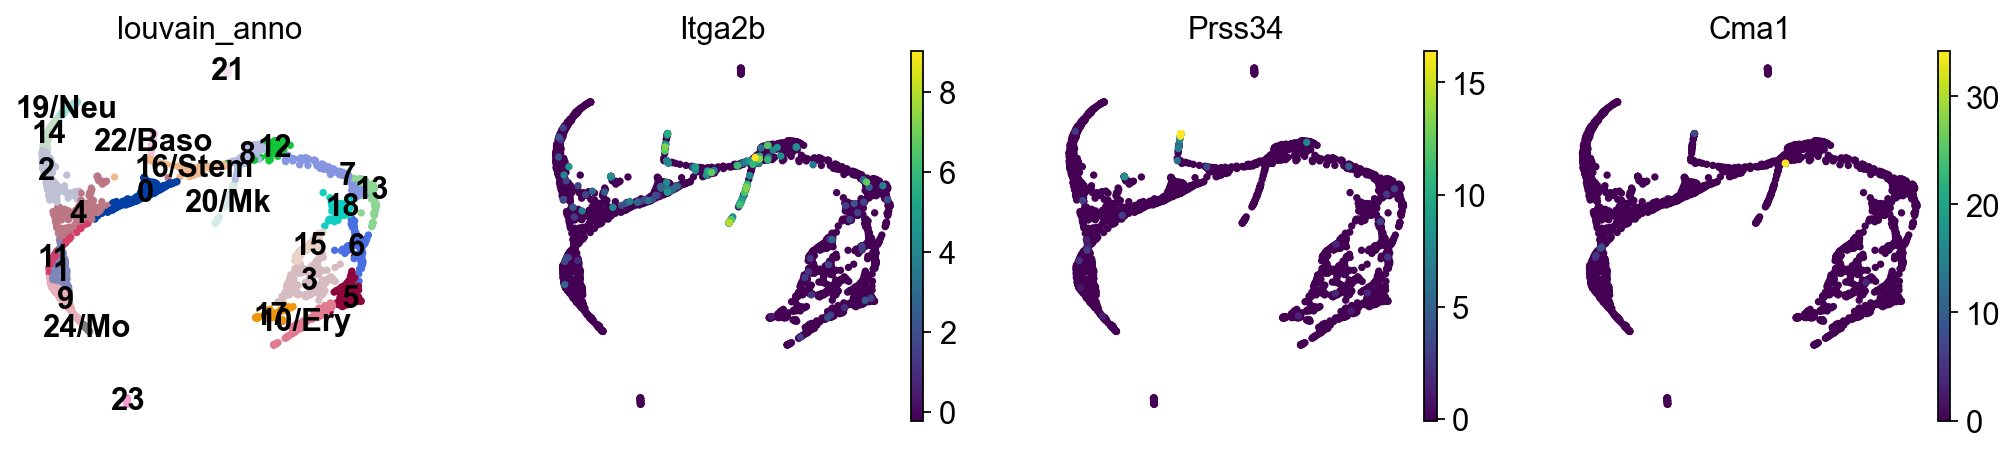

In [23]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

Choose the colors of the clusters a bit more consistently.

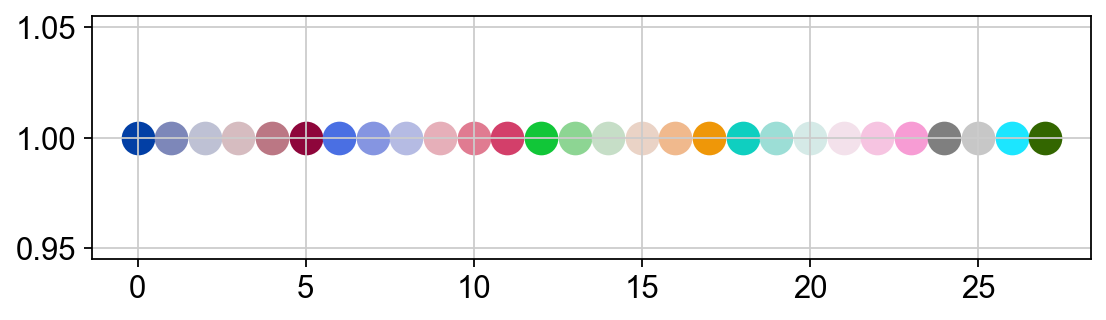

In [24]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [25]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [26]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [27]:
adata.uns['louvain_anno_colors'] = new_colors

And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found [here](https://github.com/theislab/paga/blob/f53fcdf4a861b7d3410f8096ffc13a07f1d225c0/blood/paul15/paul15.ipynb). These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

--> added 'pos', the PAGA positions (adata.uns['paga'])


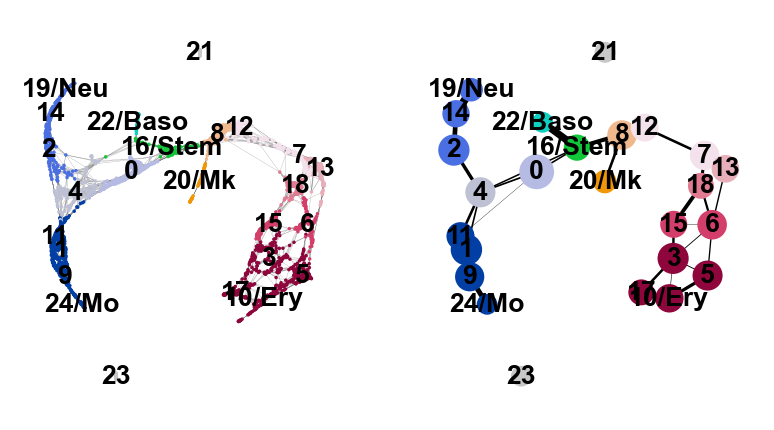

In [28]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime.

In [29]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]

In [30]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Select some of the marker gene names.

In [31]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

Use the full raw data for visualization.

In [32]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

C:\Users\Admin\.conda\envs\IDOL\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


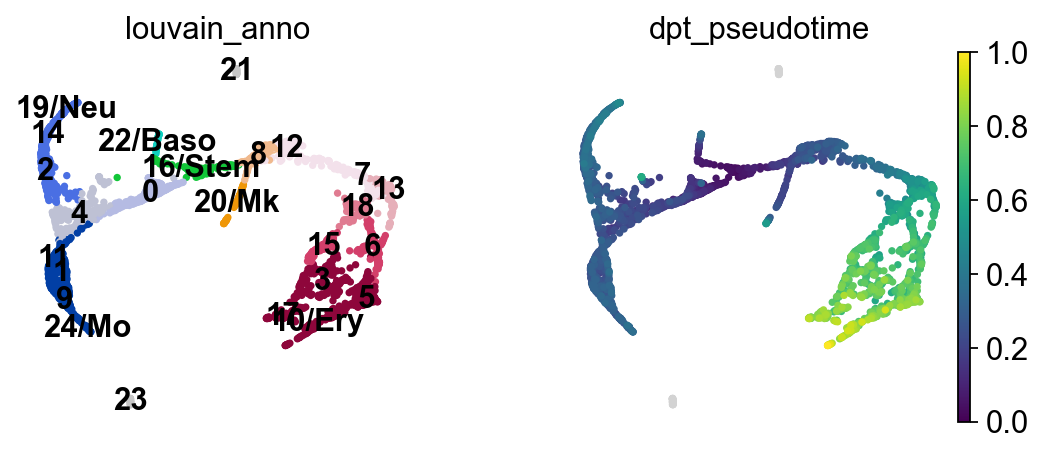

In [33]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [34]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [35]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [36]:
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change

In [37]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [38]:
!mkdir write

A subdirectory or file write already exists.


C:\Users\Admin\.conda\envs\IDOL\lib\site-packages\scanpy\plotting\_tools\paga.py:1226: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
C:\Users\Admin\.conda\envs\IDOL\lib\site-packages\scanpy\plotting\_tools\paga.py:1273: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


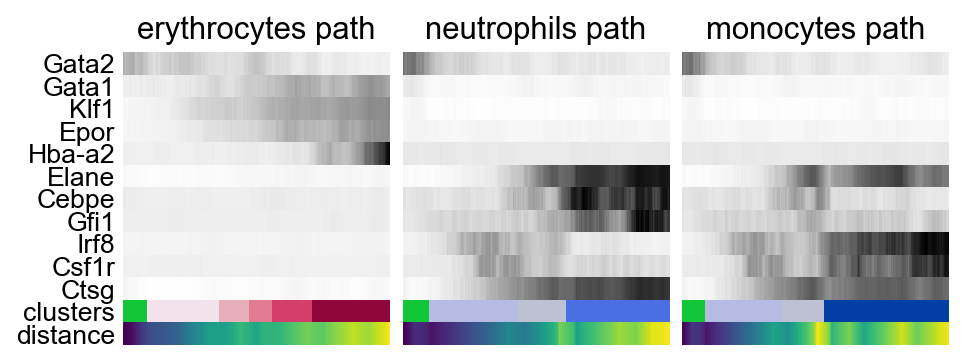

In [39]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()

In [40]:
adata

AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all', 'louvain', 'louvain_anno', 'dpt_pseudotime', 'distance', 'clusters'
    var: 'n_counts', 'mean', 'std'
    uns: 'iroot', 'log1p', 'pca', 'neighbors', 'draw_graph', 'paul15_clusters_colors', 'diffmap_evals', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'louvain_anno_sizes', 'louvain_anno_colors', 'clusters_colors'
    obsm: 'X_pca', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [41]:
adata.write(filename='cleaded_sample_data.h5ad')

In [42]:
import anndata
#adata = anndata.read_h5ad(filename='cleaded_sample_data.h5ad')
adata = anndata.read_h5ad(filename='cleaded_sample_data_with_original_values.h5ad')
adata

AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all', 'louvain', 'louvain_anno', 'dpt_pseudotime', 'distance', 'clusters'
    var: 'n_counts', 'mean', 'std'
    uns: 'clusters_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'louvain_anno_colors', 'louvain_anno_sizes', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [43]:
adata.obs['dpt_pseudotime']

0       0.225547
1       0.273524
2       0.710179
3       0.267904
4       0.781939
          ...   
2725    0.649140
2726    0.298521
2727    0.196117
2728    0.264164
2729    0.762039
Name: dpt_pseudotime, Length: 2730, dtype: float32

In [44]:
adata.obs

,paul15_clusters,n_counts_all,louvain,louvain_anno,dpt_pseudotime,distance,clusters
0,7MEP,353.0,8,8,0.225547,0.225547,8
1,15Mo,2556.0,1,1,0.273524,0.273524,1
2,3Ery,4649.0,17,17,0.710179,0.710179,17
3,15Mo,4486.0,2,2,0.267904,0.267904,2
4,3Ery,5205.0,17,17,0.781939,0.781939,17
...,...,...,...,...,...,...,...
2725,2Ery,4873.0,6,6,0.649140,0.649140,6
2726,13Baso,3553.0,24,24/Mo,0.298521,0.298521,24/Mo
2727,7MEP,443.0,8,8,0.196117,0.196117,8
2728,15Mo,3252.0,2,2,0.264164,0.264164,2


In [45]:
with open("gene2vec_dim_200_iter_9.txt", "r") as f:
    lines = f.readlines()
    gene_dict = dict()
    encoding_size = 200
    for line in lines:
        split = line.split("\t")
        name = split[0].lower()
        str_encoding = split[1].split(" ")[:encoding_size]
        float_encoding = list(map(float, str_encoding))
        gene_dict[name] = float_encoding
len(gene_dict.keys())

24445

In [46]:
most_varied_genes = list(adata.var.nlargest(100,"std").index)
most_varied_genes

['Prtn3',
 'Elane',
 'Car1',
 'Car2',
 'Ctsg',
 'Mpo',
 'H2afy',
 'Fam132a',
 'Apoe',
 'Lgals1',
 'Calr',
 'Mt2',
 'Blvrb',
 'Ly6c2',
 'Coro1a',
 'Mt1',
 'Prdx2',
 'Srgn',
 'Klf1',
 'Laptm5',
 'Vim',
 'Rpl23',
 'Pkm2',
 'Tuba1b',
 'Cst3',
 'Arhgdib',
 'Lgals9',
 'Malat1',
 'Sh3bgrl3',
 'P4hb',
 'Fth1',
 'Zfpm1',
 'Hspa5',
 'Vamp5',
 'Atpif1',
 'Ermap',
 'Psmb8',
 'Hsp90b1',
 'Ly6e',
 'Gstm1',
 'Cpox',
 'Rac2',
 'Aqp1',
 'Glrx5',
 'Myc',
 'Alas1',
 'Mthfd1',
 'Gpr56',
 'Top2a',
 'Mns1',
 'Atpase6',
 'Ramp1',
 'Mrpl52',
 'Myb',
 'Hk1',
 'Chd4',
 'Tagln2',
 'H2-K1',
 'Gpi1',
 'Rpl32',
 'Bat2d',
 'Igfbp4',
 'Arpc1b',
 'Alad',
 'Tnfaip2',
 'Cbfa2t3',
 'Ncl',
 'Cenp-a',
 'Ccnd2',
 'Ube2c',
 'Ptprcap',
 'Sphk1',
 'Creg1',
 'Ctbp1',
 'Srrm2',
 'Mdh2',
 'Hp',
 'Lig1',
 'Hn1',
 'Gm10653',
 'Manf',
 'S100a10',
 'Nedd4',
 'Uqcr',
 'Gnai2',
 'Cfl1',
 'Nucb1',
 'Emp3',
 'Tyrobp',
 'Ddx24',
 'Nkg7',
 'Atp1b2',
 'Clic1',
 'Tpm3',
 'Fxyd5',
 'Rbm39',
 'Tgfb1',
 'Vamp8',
 'Mapkapk2',
 'Mrpl12']

In [47]:
included_gene_names = []
reduced_gene_names = []
include_gene_max = 75
for gene in most_varied_genes:
    if gene.lower() in gene_dict and len(included_gene_names) < include_gene_max:
        included_gene_names.append(gene)
        reduced_gene_names.append(gene.lower())
included_gene_names

['Prtn3',
 'Elane',
 'Ctsg',
 'Mpo',
 'H2afy',
 'Fam132a',
 'Apoe',
 'Lgals1',
 'Calr',
 'Blvrb',
 'Coro1a',
 'Prdx2',
 'Srgn',
 'Klf1',
 'Laptm5',
 'Vim',
 'Rpl23',
 'Tuba1b',
 'Cst3',
 'Arhgdib',
 'Lgals9',
 'Malat1',
 'Sh3bgrl3',
 'P4hb',
 'Fth1',
 'Zfpm1',
 'Hspa5',
 'Vamp5',
 'Atpif1',
 'Ermap',
 'Psmb8',
 'Hsp90b1',
 'Ly6e',
 'Gstm1',
 'Cpox',
 'Rac2',
 'Aqp1',
 'Glrx5',
 'Myc',
 'Alas1',
 'Mthfd1',
 'Gpr56',
 'Top2a',
 'Mns1',
 'Ramp1',
 'Mrpl52',
 'Myb',
 'Hk1',
 'Chd4',
 'Tagln2',
 'Rpl32',
 'Igfbp4',
 'Arpc1b',
 'Alad',
 'Tnfaip2',
 'Cbfa2t3',
 'Ncl',
 'Ccnd2',
 'Ube2c',
 'Ptprcap',
 'Sphk1',
 'Creg1',
 'Ctbp1',
 'Srrm2',
 'Mdh2',
 'Hp',
 'Lig1',
 'Hn1',
 'Manf',
 'S100a10',
 'Nedd4',
 'Gnai2',
 'Cfl1',
 'Nucb1',
 'Emp3']

In [48]:
adata

AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all', 'louvain', 'louvain_anno', 'dpt_pseudotime', 'distance', 'clusters'
    var: 'n_counts', 'mean', 'std'
    uns: 'clusters_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'louvain_anno_colors', 'louvain_anno_sizes', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [49]:
import anndata

In [50]:
read_anndata = anndata.read_h5ad(filename='cleaded_sample_data.h5ad')
read_anndata

AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all', 'louvain', 'louvain_anno', 'dpt_pseudotime', 'distance', 'clusters'
    var: 'n_counts', 'mean', 'std'
    uns: 'clusters_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'louvain_anno_colors', 'louvain_anno_sizes', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [51]:
import torch

In [52]:
cell_pseudotimes = torch.tensor(adata.obs['dpt_pseudotime'])
cell_pseudotimes.shape

torch.Size([2730])

In [53]:
bdata = sc.datasets.paul15()

C:\Users\Admin\.conda\envs\IDOL\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [54]:
expression_max = np.array(bdata[:, bdata.var_names.isin(included_gene_names)].X).max()
expressions = np.log(np.array(bdata[:, bdata.var_names.isin(included_gene_names)].X)+1)
expressions

array([[0.       , 0.       , 0.6931472, ..., 0.       , 0.6931472,
        0.       ],
       [0.       , 2.3025851, 1.0986123, ..., 0.6931472, 1.3862944,
        0.       ],
       [1.609438 , 0.       , 0.6931472, ..., 0.6931472, 0.       ,
        2.0794415],
       ...,
       [0.       , 0.       , 1.609438 , ..., 0.6931472, 0.       ,
        0.6931472],
       [1.3862944, 1.3862944, 0.       , ..., 0.       , 1.3862944,
        0.6931472],
       [1.3862944, 0.6931472, 0.6931472, ..., 2.4849067, 0.       ,
        2.6390574]], dtype=float32)

In [55]:
cell_data = torch.tensor(expressions)
cell_data.shape

torch.Size([2730, 75])

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

import torch

In [57]:
cell_data_and_time = torch.cat([cell_pseudotimes.reshape([cell_pseudotimes.shape[0],-1]),cell_data], dim=1)
cell_data_and_time.shape

torch.Size([2730, 76])

In [58]:
sorted_cell_data_and_time, indices = torch.sort(cell_data_and_time,dim=0)

In [59]:
indices[:,0][1000]

tensor(1235)

In [60]:
sorted_cell_data_and_time

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0169, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0173, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [   inf, 2.7726, 3.0910,  ..., 2.8332, 2.9444, 2.9444],
        [   inf, 2.8332, 3.0910,  ..., 2.8904, 3.0910, 3.0445],
        [   inf, 2.9444, 3.3673,  ..., 3.0910, 3.2189, 3.0910]])

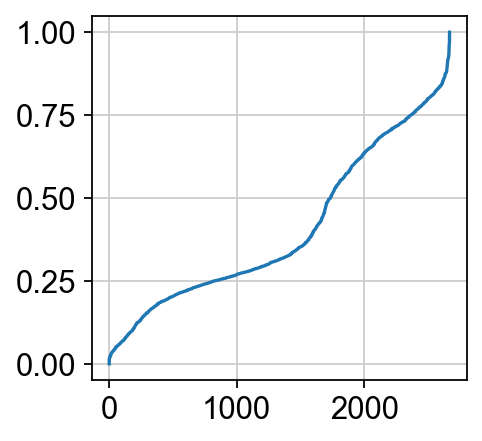

In [61]:
plt.plot(sorted_cell_data_and_time[:,0])

In [62]:
sorted_cell_data_and_time[:,1:].shape

torch.Size([2730, 75])

In [63]:
cell_count = cell_data.shape[0]
shape = (cell_count,cell_count)
print(cell_count)
#cell_count = 2
distances = np.zeros(shape)
max_time = 0.1
max_distance = float('inf')
for i in tqdm(range(cell_count)):
    for j in range(i,cell_count):
        if i == j:
            distances[i][i] = 0.0
        else:
            cell_i = cell_data[i]
            cell_j = cell_data[j]
            if cell_pseudotimes[i] - cell_pseudotimes[j] > max_time:
                distances[i][j] = float('inf')
                distances[j][i] = float('-inf')
            elif cell_pseudotimes[i] - cell_pseudotimes[j] < -max_time:
                distances[i][j] = float('-inf')
                distances[j][i] = float('inf')
            else:
                distance = np.linalg.norm(cell_i - cell_j)
                if distance > max_distance:
                    distance = float('inf')
                if cell_pseudotimes[i] >= cell_pseudotimes[j]:
                    distance = -distance
                distances[i][j] = distance
                distances[j][i] = -distance

2730


100%|██████████████████████████████████████████████████████████████████████████████| 2730/2730 [02:02<00:00, 22.28it/s]


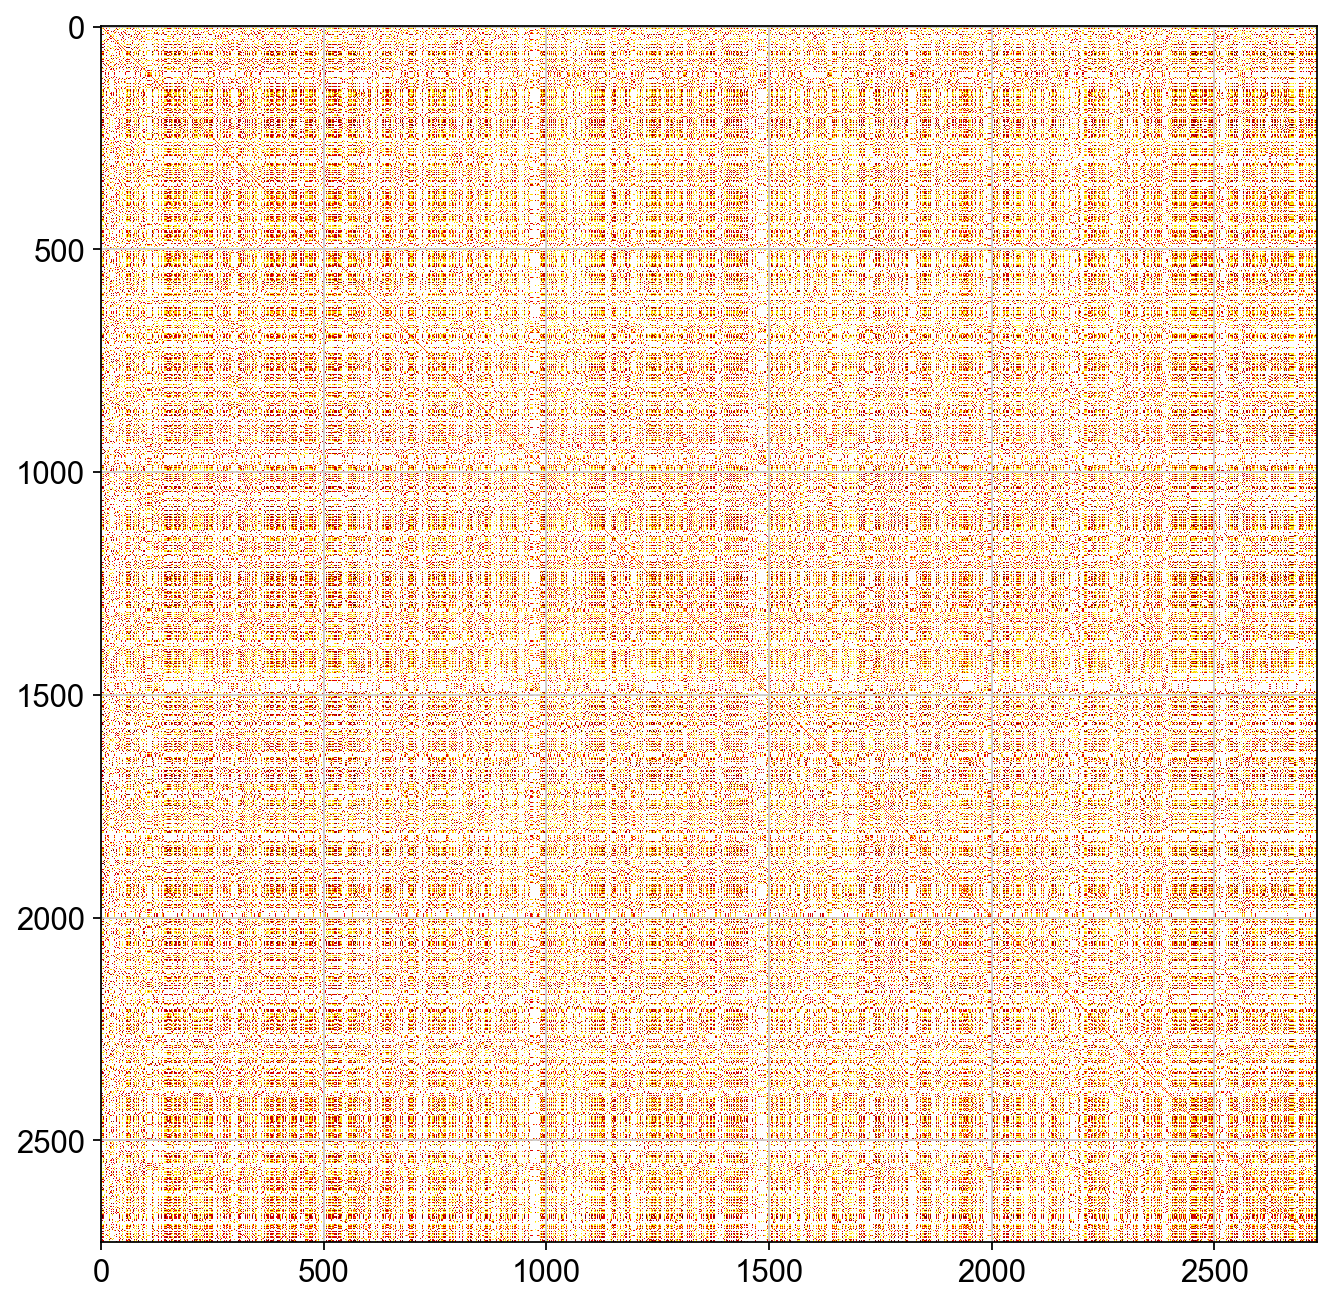

In [64]:
fig, ax = plt.subplots()
plt.imshow(distances, cmap='hot', interpolation='nearest')
fig.set_size_inches(10, 10)
plt.show()

In [65]:
cell_neighbors = []
for i in range(cell_count):
    neighbors = []
    for j in range(cell_count):
        if distances[i][j] > 0 and distances[i][j] != float('inf'):
            neighbors.append(j)
    #print(i, neighbors)
    cell_neighbors.append(neighbors)

In [66]:
neighbor_counts = []
for neighbors in cell_neighbors:
    neighbor_counts.append(len(neighbors))

In [67]:
count = 0
for neighbor_count in neighbor_counts:
    if neighbor_count == 0:
        count = count + 1
count

2

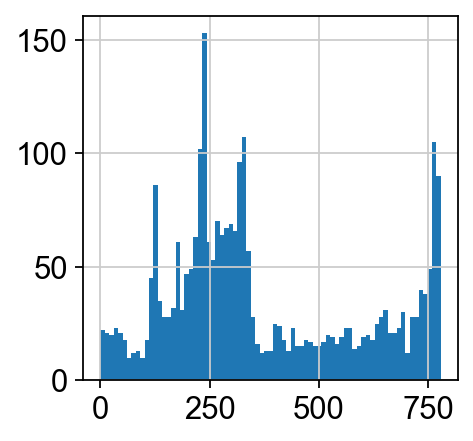

In [68]:
plt.hist(neighbor_counts, max(neighbor_counts)//10)
plt.show()

In [69]:
def generate_path(cell_id, cell_data, cell_neighbors, max_path_length):
    if cell_neighbors[cell_id] == []:
        return [cell_id]
    next_cell_id = random.choice(cell_neighbors[cell_id])
    if max_path_length <= 1:
        return [cell_id]
    
    return [cell_id] + generate_path(next_cell_id, cell_data, cell_neighbors, max_path_length - 1)

In [70]:
path_lengths = []
max_path_length = 100
for i in range(50000):
    cell_id = random.randint(0,cell_count-1)
    path_lengths.append(len(generate_path(cell_id, cell_data, cell_neighbors, max_path_length)))

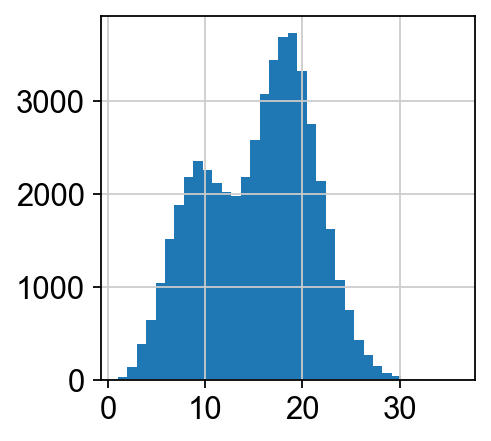

In [71]:
path_len_array = np.array(path_lengths)
plt.hist(path_len_array,bins=path_len_array.max())
plt.show()

In [72]:
cell_neighbor_tensor = np.log(torch.tensor(neighbor_counts)+1)
cell_neighbor_tensor = cell_neighbor_tensor.reshape((-1,1))
cell_neighbor_tensor.shape

torch.Size([2730, 1])

In [73]:
cell_pseudotimes = cell_pseudotimes.reshape((-1,1))
cell_pseudotimes.shape

torch.Size([2730, 1])

In [74]:
cell_data_tensor = cell_data
cell_data_tensor.shape

torch.Size([2730, 75])

In [75]:
expanded_cell_data = torch.cat((cell_pseudotimes, cell_neighbor_tensor, cell_data_tensor),1)
expanded_cell_data.shape

torch.Size([2730, 77])

In [76]:
print("PseudoTime:", cell_pseudotimes[0])
print("Neighbors:", cell_neighbor_tensor[0])
print("ExpressionData:", cell_data_tensor[0])
print("CombinedData:", expanded_cell_data[0])

PseudoTime: tensor([0.2255])
Neighbors: tensor([6.6359], dtype=torch.float64)
ExpressionData: tensor([0.0000, 0.0000, 0.6931, 0.6931, 0.6931, 0.6931, 0.0000, 0.0000, 0.6931,
        1.6094, 0.6931, 0.6931, 1.0986, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0986, 0.0000, 0.0000, 1.0986, 0.0000, 0.6931, 0.6931,
        1.0986, 0.0000, 0.6931, 1.0986, 0.0000, 0.6931, 0.0000, 0.0000, 0.0000,
        1.0986, 0.0000, 0.0000, 0.0000, 0.6931, 1.0986, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0986, 0.0000, 0.6931, 0.0000,
        0.6931, 0.6931, 0.0000, 0.6931, 0.6931, 0.0000, 0.6931, 1.6094, 0.0000,
        0.0000, 0.0000, 1.0986, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.6931, 0.0000])
CombinedData: tensor([0.2255, 6.6359, 0.0000, 0.0000, 0.6931, 0.6931, 0.6931, 0.6931, 0.0000,
        0.0000, 0.6931, 1.6094, 0.6931, 0.6931, 1.0986, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0986, 0.0000, 0.0

In [77]:
paths = []
path_lengths = []
max_path_length = 10
min_path_length = 10
path_count = 10
while len(paths) < 10:
    cell_id = random.randint(0,len(cell_data)-1)
    new_path = generate_path(cell_id, cell_data, cell_neighbors, max_path_length)
    if len(new_path) >= min_path_length:
        paths.append(new_path)
        path_lengths.append(len(new_path))

In [78]:
path_lengths

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

In [79]:
paths

[[2220, 2611, 2366, 1981, 2639, 2325, 508, 128, 1722, 2050],
 [1735, 2150, 467, 1552, 1562, 913, 1640, 2462, 298, 2645],
 [2071, 2374, 402, 1618, 2224, 1468, 1965, 1066, 1554, 1669],
 [1177, 1215, 561, 1661, 1612, 2224, 1509, 1232, 1028, 1596],
 [1460, 1381, 2426, 31, 137, 1662, 1105, 780, 944, 273],
 [782, 2233, 644, 749, 141, 707, 2030, 1487, 2014, 1727],
 [1745, 1982, 1231, 2521, 2193, 2491, 496, 2615, 1460, 210],
 [949, 991, 919, 2279, 914, 350, 1472, 1219, 866, 1279],
 [2424, 2393, 655, 2729, 1106, 137, 256, 882, 101, 35],
 [730, 40, 131, 955, 1205, 298, 882, 273, 2469, 871]]

In [80]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [81]:
default_encoding = []
for reduced_gene_name in reduced_gene_names:
    default_encoding.append(gene_dict[reduced_gene_name])
default_encoding = np.array(default_encoding)
default_encoding

array([[-0.43725753  , -0.21533898  , -0.1072614   , ..., -0.101038    ,
        -0.0065881666,  0.0892746   ],
       [-0.2836914   , -0.41704395  ,  0.31865078  , ..., -0.37097508  ,
        -0.12037145  ,  0.1457488   ],
       [-0.2071425   , -0.39678812  , -0.08668543  , ..., -0.20964885  ,
        -0.30792016  ,  0.01264441  ],
       ...,
       [-0.044581067 , -0.07934094  , -0.044053007 , ..., -0.3044088   ,
         0.06796624  ,  0.04464029  ],
       [ 0.0025748792, -0.041819602 , -0.15579832  , ..., -0.25843114  ,
        -0.33493966  ,  0.05273653  ],
       [ 0.19057436  ,  0.31490847  , -0.1278137   , ..., -0.6282063   ,
         0.0794845   ,  0.21718584  ]])

In [82]:
default_encoding.shape

(75, 200)

In [83]:
encoding_tensor = torch.tensor(default_encoding)
encoding_tensor.shape

torch.Size([75, 200])

In [84]:
def path_to_gene_expressions(path, cell_data):
    gene_expressions = []
    for cell_id in path:
        for expression in cell_data[cell_id]:
            gene_expressions.append(expression)
    out = torch.tensor(gene_expressions)
    out = out.reshape((1,-1))
    return out 

In [85]:
def paths_to_gene_expressions(paths, cell_data):
    tensor_list = []
    for path in paths:
        tensor_list.append(path_to_gene_expressions(path, cell_data))
    out = torch.cat(tensor_list).reshape((len(paths),-1))
    print('out', out.shape)
    return out 

In [86]:
def path_to_gene_extended_expressions(path, cell_data):
    gene_expressions = []
    for cell_id in path:
        time_data = cell_data[cell_id][0]
        position_data = cell_data[cell_id][1]
        gene_data = cell_data[cell_id][2:]
        for expression in gene_data:
            gene_expressions.append([time_data, position_data, expression])
    out = torch.tensor(gene_expressions)
    return out

In [87]:
def paths_to_gene_extended_expressions(paths, cell_data):
    tensor_list = []
    for path in paths:
        tensor_list.append(path_to_gene_extended_expressions(path, cell_data))
    out = torch.cat(tensor_list).reshape((len(paths),-1,3)).float()
    print('out', out.shape)
    return out 

In [88]:
extended_expression_tensor = paths_to_gene_extended_expressions(paths, expanded_cell_data)

out torch.Size([10, 750, 3])


In [89]:
extended_expression_tensor[0]

tensor([[0.2325, 6.6147, 0.0000],
        [0.2325, 6.6147, 0.6931],
        [0.2325, 6.6147, 0.0000],
        ...,
        [0.7354, 5.5797, 1.6094],
        [0.7354, 5.5797, 0.0000],
        [0.7354, 5.5797, 1.3863]])

In [90]:
# Code structure from https://www.youtube.com/watch?v=U0s0f995w14

import torch
import torch.nn as nn
import copy
import time
from torch.utils.tensorboard import SummaryWriter

In [91]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size)

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, queries, mask, log_attention):
        N = queries.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Split embedding into self.head pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention  = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        if log_attention:
            return [self.fc_out(out), attention]
        out = self.fc_out(out)
        return [out,None]

In [92]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask, log_attention):
        #print('Transformer', value.shape, key.shape, query.shape, mask.shape)
        attention, attention_log = self.attention(value, key, query, mask, log_attention)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return [out,attention_log]

In [93]:
class TemporalEncoding(nn.Module):
    def __init__(self, device, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        self.device = device
        '''
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        '''
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        #print('TemporalEncoding input shape', x.shape)
        shift = torch.arange(self.d_model//2).repeat(x.shape[0]* x.shape[1],1).reshape(x.shape[0], x.shape[1], -1)
        #print(shift.shape)
        x = x.repeat_interleave(self.d_model//2, 1).reshape(x.shape[0], x.shape[1], -1)
        x = torch.sin(shift + x)
        x = torch.nn.functional.pad(x, (self.d_model - x.shape[-1],0), mode='constant', value=0.0)
        #print('TemportalEncoding output shape', x.shape)
        return self.dropout(x)

In [94]:
class SpacialEncoding(nn.Module):
    def __init__(self, device, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        self.device = device
        '''
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        '''
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        #print('Spacial Encoding input shape', x.shape)
        shift = torch.arange(self.d_model//2).repeat(x.shape[0]* x.shape[1],1).reshape(x.shape[0], x.shape[1], -1)
        x = x.repeat_interleave(self.d_model//2, 1).reshape(x.shape[0], x.shape[1], -1)
        x = torch.sin(shift + x)
        x = torch.nn.functional.pad(x, (0,self.d_model - x.shape[-1]), mode='constant', value=0.0)
        #print('Spacial Encoding output shape', x.shape)
        return self.dropout(x)

In [95]:
class Encoder(nn.Module):
    def __init__(
        self,
        gene_embedding_size,
        preset_gene_embedding,
        max_neighbors,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.emebed_size = emebed_size
        self.preset_gene_embedding = preset_gene_embedding
        self.device = device
        self.gene_expression_embedding = nn.Sequential(
            nn.Linear(1, embed_size)
        )
        self.gene_name_embedding = nn.Sequential(
            nn.Linear(gene_embedding_size, embed_size)
        )
        self.time_embedding = TemporalEncoding(device, embed_size, dropout)
        self.space_embedding = SpacialEncoding(device, embed_size, dropout)
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout = dropout,
                    forward_expansion = forward_expansion,
                    )
                for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask, log_attention):
        #print(x.is_cuda, mask.is_cuda)
        N, seq_length, _ = x.shape
        X_time = x[:,:,0].reshape(-1,1)
        #print('X_time', X_time.shape)
        X_space = x[:,:,1].reshape(-1,1)
        #print('X_space', X_space.shape)
        X_gene_expressions = x[:,:,2].reshape(-1,1)
        #print('X_time', X_time.shape)
        #print('X_space', X_space.shape)
        #print('X_gene_expressions', X_gene_expressions.shape)
        
        expanded_encoding = preset_gene_embedding.repeat(N, seq_length//preset_gene_embedding.shape[0],1)
        gene_expression_embedding_result = self.gene_expression_embedding(X_gene_expressions).reshape(N,seq_length,-1)
        gene_name_embedding_result = self.gene_name_embedding(expanded_encoding).reshape(N,seq_length,-1)
        time_embedding_result = self.time_embedding(X_time).reshape(N,seq_length,-1)
        space_embedding_result = self.space_embedding(X_space).reshape(N,seq_length,-1)
        #print("gene_expression_embedding_result shape", gene_expression_embedding_result.shape)
        #print("gene_name_embedding_result", gene_name_embedding_result.shape)
        #print("time_embedding_result", time_embedding_result.shape)
        #print("space_embedding_result", space_embedding_result.shape)
        out = self.dropout(gene_expression_embedding_result + gene_name_embedding_result + time_embedding_result + space_embedding_result)
        attention_log = dict()
        layer_count = 0
        for layer in self.layers:
            out, layer_attention_log = layer(out, out, out, mask, log_attention)
            if log_attention:
                attention_log[f'encoder_layer_{layer_count}'] = layer_attention_log
                layer_count = layer_count + 1
            return [out, attention_log]
        return out

In [96]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)
        self.device = device
    def forward(self, x, value, key, src_mask, trg_mask, log_attention):
        attention, _ = self.attention(x,x,x, trg_mask, log_attention)
        query = self.dropout(self.norm(attention + x))
        out, attention_log = self.transformer_block(value, key, query, src_mask, log_attention)
        return [out, attention_log]

In [97]:
class Decoder(nn.Module):
    def __init__(self, 
                output_size,
                gene_embedding_size,
                embed_size,
                num_layers,
                heads,
                forward_expansion,
                dropout,
                device,
                max_length
    ):
        super(Decoder, self).__init__()        
        self.device = device
        self.emebed_size = emebed_size
        self.preset_gene_embedding = preset_gene_embedding
        self.device = device
        self.gene_expression_embedding = nn.Sequential(
            nn.Linear(1, embed_size)
        )
        self.gene_name_embedding = nn.Sequential(
            nn.Linear(gene_embedding_size, embed_size)
        )
        self.time_embedding = TemporalEncoding(device, embed_size, dropout)
        self.space_embedding = SpacialEncoding(device, embed_size, dropout)
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout = dropout,
                    forward_expansion = forward_expansion,
                    )
                for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)

        self.gene_embedding = nn.Sequential(
            nn.Linear(1, embed_size)
        )
        self.gene_position_embedding = nn.Sequential(
            nn.Linear(gene_embedding_size, embed_size)
        )
        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
            for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(embed_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask, log_attention):
        '''
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.gene_embedding(x) + self.position_embedding(positions))
        ''''''
        N, seq_length, _ = x.shape
        X = x.reshape(-1,1)
        expanded_encoding = preset_gene_embedding.repeat(N, seq_length//preset_gene_embedding.shape[0],1)
        gene_embedding_result = self.gene_embedding(X).reshape(N,seq_length,-1)
        gene_position_embedding_result = self.gene_position_embedding(expanded_encoding)
        out = self.dropout(gene_position_embedding_result + gene_position_embedding_result)
        print('out', out.shape)
        for layer in self.layers:
            x = layer(out, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)
        '''
        N, seq_length, _ = x.shape
        X_time = x[:,:,0].reshape(-1,1)
        #print('X_time', X_time.shape)
        X_space = x[:,:,1].reshape(-1,1)
        #print('X_space', X_space.shape)
        X_gene_expressions = x[:,:,2].reshape(-1,1)
        #print('X_time', X_time.shape)
        #print('X_space', X_space.shape)
        #print('X_gene_expressions', X_gene_expressions.shape)
        
        expanded_encoding = preset_gene_embedding.repeat(N, seq_length//preset_gene_embedding.shape[0],1)
        gene_expression_embedding_result = self.gene_expression_embedding(X_gene_expressions).reshape(N,seq_length,-1)
        gene_name_embedding_result = self.gene_name_embedding(expanded_encoding).reshape(N,seq_length,-1)
        time_embedding_result = self.time_embedding(X_time).reshape(N,seq_length,-1)
        space_embedding_result = self.space_embedding(X_space).reshape(N,seq_length,-1)
        
        #print("gene_expression_embedding_result shape", gene_expression_embedding_result.shape)
        #print("gene_name_embedding_result", gene_name_embedding_result.shape)
        #print("time_embedding_result", time_embedding_result.shape)
        #print("space_embedding_result", space_embedding_result.shape)
        out = self.dropout(gene_expression_embedding_result + gene_name_embedding_result + time_embedding_result + space_embedding_result)
        #print('out', out.shape)
        attention_log = dict()
        layer_count = 0
        for layer in self.layers:
            x, layer_attention_log = layer(out, enc_out, enc_out, src_mask, trg_mask, log_attention)
            if log_attention:
                attention_log[f'decoder_layer_{layer_count}'] = layer_attention_log
                layer_count = layer_count + 1
            return [self.fc_out(x), attention_log]
        out = self.fc_out(x)
        return out

In [98]:
class Transformer(nn.Module):
    def __init__(self,
                 gene_embedding_size,
                 preset_gene_embedding,
                 max_neighbors,
                 output_size,
                 src_pad_idx,
                 trg_pad_idx,
                 embed_size,
                 num_layers,
                 forward_expansion,
                 heads,
                 dropout,
                 device,
                 max_length):
        super(Transformer, self).__init__()
        self.name = f'model_{int(time.time())}'
        self.encoder = Encoder(
                gene_embedding_size,
                preset_gene_embedding,
                max_neighbors,
                embed_size,
                num_layers,
                heads,
                device,
                forward_expansion,
                dropout,
                max_length
        )

        self.decoder = Decoder( 
                output_size,
                gene_embedding_size,
                embed_size,
                num_layers,
                heads,
                forward_expansion,
                dropout,
                device,
                max_length
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, source):
        source = source[:,:,0:1].reshape(source.shape[0:2])
        src_mask = (source != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #print('src_mask.shape', src_mask.shape)
        return src_mask.to(self.device)

    def make_trg_mask(self, source, target):
        target = target[:,:,0:1].reshape(source.shape[0:2])
        N, trg_len = target.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)    

    def forward(self, src, trg, log_encoder_attention=False, log_decoder_attention=False):
        src_mask = self.make_src_mask(src)
        trg_mask_shape = list(trg.shape)
        trg_mask_shape.append(-1)
        trg_mask = self.make_trg_mask(src, trg)
        
        #print(src.is_cuda, src_mask.is_cuda,trg_mask.is_cuda, trg.is_cuda)
        
        attention_log = dict()
        enc_src, encoder_attention_log = self.encoder(src, src_mask, log_encoder_attention)
        attention_log['encoder'] = encoder_attention_log
        #print(enc_src.is_cuda)
        out, decoder_attention_log= self.decoder(trg, enc_src, src_mask, trg_mask, log_decoder_attention)
        attention_log['decoder'] = decoder_attention_log
        
        if log_encoder_attention or log_decoder_attention:
            return [out, attention_log]
        return out

In [99]:
max_neighbor_count = max(neighbor_counts)
max_neighbor_count

779

In [100]:
#src = extended_expression_tensor[:,:,:]
#trg = torch.nn.functional.pad(extended_expression_tensor[:,1:,:], (0,0,0,1), "constant", 0)
#out = model(src, trg)
#out.shape

In [101]:
def create_dataset(path_count, expanded_cell_data, max_path_length = 10, min_path_length = 10, starting_cell_id=None, return_paths=False):
    paths = []
    path_lengths = []
    expanded_paths = []
    while len(paths) < path_count:
        if starting_cell_id is None:
            cell_id = random.randint(0,len(cell_data)-1)
        else:
            cell_id = starting_cell_id
        new_path = generate_path(cell_id, cell_data, cell_neighbors, max_path_length)
        if len(new_path) >= min_path_length:
            expanded_path = path_to_gene_extended_expressions(new_path, expanded_cell_data)
            if expanded_path.isfinite().all():
                paths.append(new_path)
                path_lengths.append(len(new_path))
                expanded_paths.append(expanded_path)
    expanded_paths = torch.cat(expanded_paths).reshape((len(paths),-1,3)).float()
    if return_paths:
        return [expanded_paths, paths]
    return expanded_paths

In [102]:
gene_embedding_size = 200
output_size = 3
src_pad_idx = 0
trg_pad_idx = 0
emebed_size = 32
num_layers=3
forward_expansion=4
heads=2
dropout=0
#device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
max_length=10
preset_gene_embedding = encoding_tensor.float()
max_neighbors = max_neighbor_count
model = Transformer(gene_embedding_size, preset_gene_embedding, max_neighbors, output_size, src_pad_idx, trg_pad_idx, emebed_size, num_layers, forward_expansion, heads, dropout, device, max_length).to(device)

In [103]:
training_data = create_dataset(path_count=10_000, expanded_cell_data=expanded_cell_data)
testing_data = create_dataset(path_count=1_000, expanded_cell_data=expanded_cell_data)

In [104]:
def train_model(model, device, training_data, testing_data, epochs=5,criterion=nn.L1Loss(),lr=5.0,gamma=0.95):
    print('device', device)
    print('model.device', model.device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=gamma)
    
    training_source = training_data
    training_target = torch.nn.functional.pad(training_data[:,1:,:], (0,0,0,1), "constant", 0)
    train_loss_target = training_target.reshape([training_target.shape[0],-1])
    
    test_src = testing_data
    test_trg = torch.nn.functional.pad(testing_data[:,1:,:], (0,0,0,1), "constant", 0)
    test_loss_target = test_trg.reshape([test_trg.shape[0],-1])
    
    for epoch in range(epochs):
        start_time = time.time()
        
        model.train()  # turn on train mode
        train_loss = 0
        for batch_index in range(training_source.shape[0]):
            batch_start_time = time.time()
            batch_src = training_source[batch_index:batch_index+1].to(device)
            batch_trg = training_target[batch_index:batch_index+1].to(device)
            train_targets_batch = train_loss_target[batch_index:batch_index+1].to(device)
            #print('batch_src.device', batch_src.device)
            #print('batch_trg.device', batch_trg.device)
            #print('train_targets_batch.device', train_targets_batch.device)
            train_output = model(batch_src, batch_trg).reshape(train_targets_batch.shape[0], -1)
            batch_loss =  criterion(train_output, train_targets_batch)
            train_loss = train_loss + batch_loss
            optimizer.zero_grad()
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            scheduler.step()
            if batch_index % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_index}, batch loss:{batch_loss}, batch time:{time.time() - batch_start_time}')
            # Clean up memory
            del batch_src, batch_trg, train_targets_batch, train_output, batch_loss
        
        model.eval()
        test_loss = 0
        for batch_index in range(test_src.shape[0]):
            test_src_batch = test_src[batch_index:batch_index+1].to(device)
            test_trg_batch = test_trg[batch_index:batch_index+1].to(device)
            test_targets_batch = test_loss_target[batch_index:batch_index+1].to(device)
            test_output = model(test_src_batch, test_trg_batch)
            test_output = test_output.reshape(test_targets_batch.shape[0], -1)
            test_batch_loss =  criterion(test_output, test_targets_batch)
            test_loss = test_loss + test_batch_loss
            
            del test_src_batch, test_trg_batch, test_targets_batch, test_output, test_batch_loss
        
        writer.add_scalar('train_loss', train_loss, epoch)
        writer.add_scalar('test_loss', test_loss, epoch)
        
        print(f'Epoch {epoch}, train_loss: {train_loss}, test_loss: {test_loss}, time: {time.time() - start_time}')
        del train_loss, test_loss

In [105]:
list(model.named_parameters())[0]

('encoder.gene_expression_embedding.0.weight',
 Parameter containing:
 tensor([[-0.3558],
         [-0.7374],
         [-0.9890],
         [-0.8835],
         [ 0.5087],
         [ 0.6846],
         [ 0.4095],
         [ 0.5072],
         [ 0.6884],
         [-0.4813],
         [-0.6569],
         [-0.6151],
         [ 0.3764],
         [ 0.7507],
         [-0.4317],
         [-0.5293],
         [-0.4201],
         [-0.8813],
         [ 0.3725],
         [-0.8180],
         [ 0.5854],
         [ 0.8524],
         [ 0.6272],
         [ 0.1549],
         [-0.7978],
         [ 0.6372],
         [-0.8090],
         [ 0.0604],
         [ 0.5308],
         [-0.1436],
         [ 0.4416],
         [-0.3009]], requires_grad=True))

In [106]:
cell_clusters = bdata.obs['paul15_clusters']

In [107]:
def log_list(num_list):
    log_list = []
    for num in num_list:
        try:
            log_list.append(math.log(num))
        except ValueError:
            log_list.append(float('inf'))
    return log_list

In [108]:
cell_dict = dict()
for i in range(cell_count):
    cell_dict[i] = {'expressions': cell_data[i],
                    'log_expressions': log_list(cell_data[i]),
                    'cluster': cell_clusters[i],
                    'pseudotime': cell_pseudotimes[i],
                    'distances': distances[i],
                    'neighbors': cell_neighbors[i]
                }

In [109]:
cluster_cell_dict = dict()
for i in range(cell_count):
    given_cluster = cell_dict[i]['cluster']
    if given_cluster in cluster_cell_dict:
        cluster_cell_dict[given_cluster]['times'].append(cell_dict[i]['pseudotime'])
        cluster_cell_dict[given_cluster]['cells'].append(i)
    else:
        cluster_cell_dict[given_cluster] = {'times':[cell_dict[i]['pseudotime']],
                                           'cells':[i]}

In [110]:
for key in cluster_cell_dict:
    print(key, len(cluster_cell_dict[key]['cells']))

7MEP 167
15Mo 186
3Ery 246
4Ery 124
2Ery 329
17Neu 22
14Mo 373
13Baso 300
8Mk 68
9GMP 63
10GMP 153
16Neu 164
5Ery 180
1Ery 43
6Ery 173
19Lymph 31
12Baso 69
18Eos 9
11DC 30


In [111]:
def gen_path_in_cluster(current_cell, cluster, cell_dict, level):
    if level == 0:
        return []
    else:
        

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_17420/445292266.py, line 5)

In [ ]:
def greedy_cells(current_cell, ending_cell, cell_dict):
    neighbors = cell_dict[current_cell]['neighbors']
    neighbor_distances = list()
    for neighbor in neighbors:
        distance = cell_dict[neighbor]['distances'][ending_cell]
        if distance >= 0:
            neighbor_distances.append((neighbor, distance))
    neighbor_distances.sort(key = lambda x: x[1])
    return neighbor_distances

In [ ]:
def nearest_cells(current_cell, ending_cell, cell_dict):
    neighbors = cell_dict[current_cell]['neighbors']
    neighbor_distances = list()
    for neighbor in neighbors:
        distance = cell_dict[current_cell]['distances'][neighbor]
        if distance >= 0:
            neighbor_distances.append((neighbor, distance))
    neighbor_distances.sort(key = lambda x: x[1])
    return neighbor_distances

In [ ]:
def short_path_generator(current_cell, ending_cell, cell_dict, level):
    print('Looking at', current_cell, level)
    if current_cell == ending_cell:
        return [ending_cell]
    else:
        neighbor_distances = nearest_cells(current_cell, ending_cell, cell_dict)
        for neighbor_distance in neighbor_distances:
            future_path = short_path_generator(neighbor_distances[0][0], ending_cell, cell_dict, level + 1)
            if future_path != []:
                return  future_path + [current_cell]
    return []

In [ ]:
def path_generator(current_cell, ending_cell, cell_dict, level):
    # print('Looking at', current_cell, level)
    if current_cell == ending_cell:
        return [ending_cell]
    else:
        neighbor_distances = greedy_cells(current_cell, ending_cell, cell_dict)
        for neighbor_distance in neighbor_distances:
            future_path = path_generator(neighbor_distances[0][0], ending_cell, cell_dict, level + 1)
            if future_path != []:
                return  future_path + [current_cell]
    return []

In [ ]:
def generate_eval_dataset(start_cluster, end_cluster, cluster_cell_dict, path_count):
    paths = []
    start_min = min(cluster_cell_dict[start_cluster]['times'])
    start_max = max(cluster_cell_dict[start_cluster]['times'])
    end_min = min(cluster_cell_dict[end_cluster]['times'])
    end_max = max(cluster_cell_dict[end_cluster]['times'])
    # print(start_cluster, start_min, start_max, end_cluster, end_min, end_max)
    if start_min >= end_max or end_min == float('inf'):
        return []
    while len(paths) < path_count:
        starting_time = float('inf')
        ending_time = float('-inf')
        while starting_time >= ending_time or ending_time == float('inf'):
            starting_cell = random.choice(cluster_cell_dict[start_cluster]['cells'])
            starting_time = cell_dict[starting_cell]['pseudotime']
            ending_cell = random.choice(cluster_cell_dict[end_cluster]['cells'])
            ending_time = cell_dict[ending_cell]['pseudotime']
            # print('Starting Cell', starting_cell, starting_time)
            # print('Ending Cell', ending_cell, ending_time)
        path = short_path_generator(starting_cell, ending_cell, cell_dict, 0)
        if len(path) > 1:
            paths.append(path)
    return paths

In [ ]:
eval_paths = []
for start_cluster in cluster_cell_dict:
    if start_cluster not in ['19Lymph', '11DC']:
        found_paths = generate_eval_dataset(start_cluster, start_cluster, cluster_cell_dict, 1)
        print(start_cluster, found_paths)
        eval_paths.append(found_paths)

In [ ]:
expanded_paths = []
for new_path in eval_paths:
    print(new_path[0])
    expanded_path = path_to_gene_extended_expressions(new_path[0], expanded_cell_data)
    expanded_paths.append(expanded_path)
expanded_paths = torch.cat(expanded_paths).reshape((len(paths),-1,3)).float()
expanded_paths.shape

In [ ]:
expanded_paths

In [ ]:
writer = SummaryWriter(f'torch/logs/{model.name}')

#training_data = create_dataset(path_count=10_000, expanded_cell_data=expanded_cell_data)
#testing_data = create_dataset(path_count=1_000, expanded_cell_data=expanded_cell_data)

train_model(model,device,training_data, testing_data)
writer.close()

In [ ]:
def eval_model(model,criterion=nn.L1Loss()):
    validation_data = create_dataset(path_count=1000, expanded_cell_data=expanded_cell_data)
    model.eval()
    validation_src = validation_data[:,:,:]
    validation_trg = torch.nn.functional.pad(validation_data[:,1:,:], (0,0,0,1), "constant", 0)

    validation_targets = validation_trg.reshape([validation_trg.shape[0],-1])
    output = model(validation_src, validation_trg)
    output = output.reshape(validation_targets.shape[0], -1)

    validation_loss = criterion(output, validation_targets)
    writer = SummaryWriter(f'torch/logs/{model.name}')
    writer.add_graph(model, [validation_src, validation_trg])
    writer.close()
    return validation_loss

In [ ]:
eval_model(model)

In [ ]:
import seaborn as sns

In [ ]:
del cluster_cell_dict['19Lymph']
del cluster_cell_dict['11DC']

In [ ]:
for key in cluster_cell_dict:
    print(key, min(cluster_cell_dict[key]['times']), max(cluster_cell_dict[key]['times']))

In [ ]:
for i in range(5):
    print(i)
    for key in cluster_cell_dict:
        time = float('inf')
        while time == float('inf'):
            starting_cell = random.choice(cluster_cell_dict[key]['cells'])
            time  = cell_dict[starting_cell]['pseudotime']
        path = f'figures\\data_output\\{key.strip()}\\{starting_cell}'
        print(key, starting_cell)
        input_data = create_dataset(path_count=1, expanded_cell_data=expanded_cell_data, starting_cell_id=starting_cell)
        gene_count = 75
        model.eval()
        input_src = input_data[:,:,:]
        input_trg = torch.nn.functional.pad(input_data[:,1:,:], (0,0,0,1), "constant", 0)
        output, attention_log = model(input_src, input_trg, log_encoder_attention=True, log_decoder_attention=True)
        input_length = input_data.shape[1]
        encoder_head_1 = attention_log['encoder']['encoder_layer_0'][:,0,:,:].reshape((input_length, input_length))
        encoder_head_2 = attention_log['encoder']['encoder_layer_0'][:,1,:,:].reshape((input_length, input_length))
        combined_encoder_heads = encoder_head_1 + encoder_head_2
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(encoder_head_1.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
        plt.savefig(path+'_encoder_head_1')
        # plt.show()
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(encoder_head_2.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
        plt.savefig(path+'_encoder_head_2')
        # plt.show()
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(combined_encoder_heads.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
        plt.savefig(path+'_combined_encoder_heads')
        # plt.show()
        decoder_head_1 = attention_log['decoder']['decoder_layer_0'][:,0,:,:].reshape((input_length, input_length))
        decoder_head_2 = attention_log['decoder']['decoder_layer_0'][:,1,:,:].reshape((input_length, input_length))
        combined_decoder_heads = decoder_head_1 + decoder_head_2
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(decoder_head_1.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
        plt.savefig(path+'_decoder_head_1')
        # plt.show()
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(decoder_head_2.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
        plt.savefig(path+'_decoder_head_2')
        # plt.show()
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(combined_decoder_heads.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
        plt.savefig(path+'_combined_decoder_heads')
        # plt.show()

In [ ]:
input_data = create_dataset(path_count=1, expanded_cell_data=expanded_cell_data, starting_cell_id=43)
model.eval()
input_src = input_data[:,:,:]
input_trg = torch.nn.functional.pad(input_data[:,1:,:], (0,0,0,1), "constant", 0)
output, attention_log = model(input_src, input_trg, log_encoder_attention=True, log_decoder_attention=True)

In [ ]:
input_length = input_data.shape[1]
gene_count = 75

In [ ]:
encoder_head_1 = attention_log['encoder']['encoder_layer_0'][:,0,:,:].reshape((input_length, input_length))
encoder_head_2 = attention_log['encoder']['encoder_layer_0'][:,1,:,:].reshape((input_length, input_length))
combined_encoder_heads = encoder_head_1 + encoder_head_2

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(encoder_head_1.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
plt.show()

In [ ]:
encoder_head_1_weights = copy.copy(encoder_head_1.detach().numpy())
encoder_head_1_weights = encoder_head_1_weights.reshape(-1)
encoder_head_1_weights.sort()
plt.plot(encoder_head_1_weights)

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(encoder_head_2.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
plt.show()

In [ ]:
encoder_head_2_weights = copy.copy(encoder_head_2.detach().numpy())
encoder_head_2_weights = encoder_head_2_weights.reshape(-1)
encoder_head_2_weights.sort()
plt.plot(encoder_head_2_weights)

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(combined_encoder_heads.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
plt.show()

In [ ]:
decoder_head_1 = attention_log['decoder']['decoder_layer_0'][:,0,:,:].reshape((input_length, input_length))
decoder_head_2 = attention_log['decoder']['decoder_layer_0'][:,1,:,:].reshape((input_length, input_length))
combined_decoder_heads = decoder_head_1 + decoder_head_2

In [ ]:
print(max(attention_log['decoder']['decoder_layer_0'].reshape([-1])))
print(max(attention_log['encoder']['encoder_layer_0'].reshape([-1])))

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(decoder_head_1.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(decoder_head_2.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(combined_decoder_heads.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
plt.show()

In [ ]:
fig, axs = plt.subplots(10,10)
fig.set_size_inches(25, 25)
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(combined_encoder_heads[i*gene_count:(i+1)*gene_count,j*gene_count:(j+1)*gene_count].detach().numpy(), cmap='magma', interpolation='nearest')
        axs[i,j].axis('off')
plt.show()

In [ ]:
fig, axs = plt.subplots(10,10)
fig.set_size_inches(25, 25)
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(combined_decoder_heads[i*gene_count:(i+1)*gene_count,j*gene_count:(j+1)*gene_count].detach().numpy(), cmap='magma', interpolation='nearest')
        axs[i,j].axis('off')
        #axs[i,j].set_title(f'Axis, [{i},{j}]')
plt.show()

In [ ]:
input_data_2 = create_dataset(path_count=1, expanded_cell_data=expanded_cell_data, starting_cell_id=1235)
model.eval()
input_src_2 = input_data_2[:,:,:]
input_trg_2 = torch.nn.functional.pad(input_data_2[:,1:,:], (0,0,0,1), "constant", 0)
output_2, attention_log_2 = model(input_src_2, input_trg_2, log_encoder_attention=True, log_decoder_attention=True)
encoder_head_1_2 = attention_log_2['encoder']['encoder_layer_0'][:,0,:,:].reshape((input_length, input_length))
encoder_head_2_2 = attention_log_2['encoder']['encoder_layer_0'][:,1,:,:].reshape((input_length, input_length))
combined_encoder_heads_2 = encoder_head_1_2 + encoder_head_2_2
decoder_head_1_2 = attention_log_2['decoder']['decoder_layer_0'][:,0,:,:].reshape((input_length, input_length))
decoder_head_2_2 = attention_log_2['decoder']['decoder_layer_0'][:,1,:,:].reshape((input_length, input_length))
combined_decoder_heads_2 = decoder_head_1_2 + decoder_head_2_2

In [ ]:
fig, axs = plt.subplots(10,10)
fig.set_size_inches(25, 25)
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(combined_encoder_heads_2[i*gene_count:(i+1)*gene_count,j*gene_count:(j+1)*gene_count].detach().numpy(), cmap='magma', interpolation='nearest')
        axs[i,j].axis('off')
        #axs[i,j].set_title(f'Axis, [{i},{j}]')
plt.show()

In [ ]:
fig, axs = plt.subplots(10,10)
fig.set_size_inches(25, 25)
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(combined_decoder_heads_2[i*gene_count:(i+1)*gene_count,j*gene_count:(j+1)*gene_count].detach().numpy(), cmap='magma', interpolation='nearest')
        axs[i,j].axis('off')
        #axs[i,j].set_title(f'Axis, [{i},{j}]')
plt.show()

In [ ]:
input_data_3, paths_input_data_3 = create_dataset(path_count=10, expanded_cell_data=expanded_cell_data, starting_cell_id=1235, return_paths=True)
model.eval()
input_src_3 = input_data_3[:,:,:]
input_trg_3 = torch.nn.functional.pad(input_data_3[:,1:,:], (0,0,0,1), "constant", 0)
output_3, attention_log_3 = model(input_src_3, input_trg_3, log_encoder_attention=True, log_decoder_attention=True)
'''
encoder_head_1_3 = attention_log_3['encoder']['encoder_layer_0'][:,0,:,:].reshape((input_length, input_length))
encoder_head_2_3 = attention_log_3['encoder']['encoder_layer_0'][:,1,:,:].reshape((input_length, input_length))
combined_encoder_heads_3 = encoder_head_1_3 + encoder_head_2_3
decoder_head_1_3 = attention_log_3['decoder']['decoder_layer_0'][:,0,:,:].reshape((input_length, input_length))
decoder_head_2_3 = attention_log_3['decoder']['decoder_layer_0'][:,1,:,:].reshape((input_length, input_length))
combined_decoder_heads_3 = decoder_head_1_3 + decoder_head_2_3
'''
paths_input_data_3

In [ ]:
encoder_head_1_3 = attention_log_3['encoder']['encoder_layer_0'][:,0,:,:].reshape((10, input_length, input_length))
encoder_head_2_3 = attention_log_3['encoder']['encoder_layer_0'][:,1,:,:].reshape((10, input_length, input_length))
combined_encoder_heads_3 = encoder_head_1_3 + encoder_head_2_3
decoder_head_1_3 = attention_log_3['decoder']['decoder_layer_0'][:,0,:,:].reshape((10, input_length, input_length))
decoder_head_2_3 = attention_log_3['decoder']['decoder_layer_0'][:,1,:,:].reshape((10, input_length, input_length))
combined_decoder_heads_3 = decoder_head_1_3 + decoder_head_2_3

In [ ]:
for path_id in range(10):
    fig, axs = plt.subplots(10,10)
    fig.suptitle(f'PATH: {paths_input_data_3[path_id]}', fontsize=25)
    fig.set_size_inches(25, 25)
    for i in range(10):
        for j in range(10):
            axs[i,j].imshow(combined_decoder_heads_3[path_id,i*gene_count:(i+1)*gene_count,j*gene_count:(j+1)*gene_count].detach().numpy(), cmap='magma', interpolation='nearest')
            axs[i,j].axis('off')
            #axs[i,j].set_title(f'Axis, [{i},{j}]')
            
    #plt.savefig(f'figures/combined_decoder_heads_3-path{paths_input_data_3[path_id]}.png')
    #plt.show()

In [ ]:
input_data

In [ ]:
limited_input_data = input_data[:,0:75,:]

In [ ]:
model.eval()
input_src = limited_input_data[:,:,:]
input_trg = torch.nn.functional.pad(limited_input_data[:,1:,:], (0,0,0,1), "constant", 0)
output, attention_log = model(input_src, input_trg, log_encoder_attention=True, log_decoder_attention=True)


In [ ]:
decoder_head_2 = attention_log['decoder']['decoder_layer_0'][:,1,:,:].reshape((75, 75))
plt.figure(figsize=(10, 10))
ax = sns.heatmap(decoder_head_2.detach().numpy(), cmap = 'magma', xticklabels=gene_count, yticklabels=gene_count)
plt.show()

In [ ]:
model_path = f'models/model_{int(time.time())}.pth'
model_path
torch.save(model.state_dict(),model_path)

In [ ]:
expanded_cell_data.shape

In [ ]:
for data in [querie_w]:
    plt.imshow( data.detach().numpy(), cmap = 'autumn' , interpolation = 'nearest' )
    plt.show()

In [ ]:
gene_embedding_size = 200
output_size = 3
src_pad_idx = 0
trg_pad_idx = 0
emebed_size = 16
num_layers=6
forward_expansion=4
heads=1
dropout=0
device='cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_length=10
preset_gene_embedding = encoding_tensor.float()
max_neighbors = max_neighbor_count
loaded_model = Transformer(gene_embedding_size, preset_gene_embedding, max_neighbors, output_size, src_pad_idx, trg_pad_idx, emebed_size, num_layers, forward_expansion, heads, dropout, device, max_length)

In [ ]:
loaded_model.eval()
validation_src = validation_data[:,:,:]
validation_trg = torch.nn.functional.pad(validation_data[:,1:,:], (0,0,0,1), "constant", 0)

validation_targets = validation_trg.reshape([trg.shape[0],-1])
output = loaded_model(validation_src, validation_trg)
output = output.reshape(targets.shape[0], -1)

validation_loss = criterion(output, validation_targets)
validation_loss

In [ ]:
loaded_model.load_state_dict(torch.load(model_path))

In [ ]:
loaded_model.eval()
validation_src = validation_data[:,:,:]
validation_trg = torch.nn.functional.pad(validation_data[:,1:,:], (0,0,0,1), "constant", 0)

validation_targets = validation_trg.reshape([trg.shape[0],-1])
output = loaded_model(validation_src, validation_trg)
output = output.reshape(targets.shape[0], -1)

validation_loss = criterion(output, validation_targets)
validation_loss

In [ ]:
loaded_model = None
model = None

In [ ]:
from torch.utils.tensorboard import SummaryWriter


In [ ]:
torch.cuda.is_available()

In [ ]:
torch.cuda.current_device()

In [ ]:
torch.cuda.get_device_name(0)

In [ ]:
torch.cuda.memory_allocated()

In [ ]:
torch.cuda

In [ ]:
var = Tensor([1,2,3]).to('cpu')
var.is_cuda

In [ ]:
model.encoder(torch.Tensor([0]),None,False)

In [ ]:
model.encoder.preset_gene_embedding

In [ ]:
x = expanded_paths[0:1]
x

In [ ]:
N, seq_length, _ = x.shape
X_time = x[:,:,0].reshape(-1,1)
#print('X_time', X_time.shape)
X_space = x[:,:,1].reshape(-1,1)
#print('X_space', X_space.shape)
X_gene_expressions = x[:,:,2].reshape(-1,1)
#print('X_time', X_time.shape)
#print('X_space', X_space.shape)
#print('X_gene_expressions', X_gene_expressions.shape)

expanded_encoding = preset_gene_embedding.repeat(N, seq_length//preset_gene_embedding.shape[0],1)
gene_expression_embedding_result = model.encoder.gene_expression_embedding(X_gene_expressions).reshape(N,seq_length,-1)
gene_name_embedding_result = model.encoder.gene_name_embedding(expanded_encoding).reshape(N,seq_length,-1)
time_embedding_result = model.encoder.time_embedding(X_time).reshape(N,seq_length,-1)
space_embedding_result = model.encoder.space_embedding(X_space).reshape(N,seq_length,-1)

#print("gene_expression_embedding_result shape", gene_expression_embedding_result.shape)
#print("gene_name_embedding_result", gene_name_embedding_result.shape)
#print("time_embedding_result", time_embedding_result.shape)
#print("space_embedding_result", space_embedding_result.shape)
out = model.encoder.dropout(gene_expression_embedding_result + gene_name_embedding_result + time_embedding_result + space_embedding_result)
